# Прогнозирование средней зарплаты

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

warnings.filterwarnings('ignore')

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


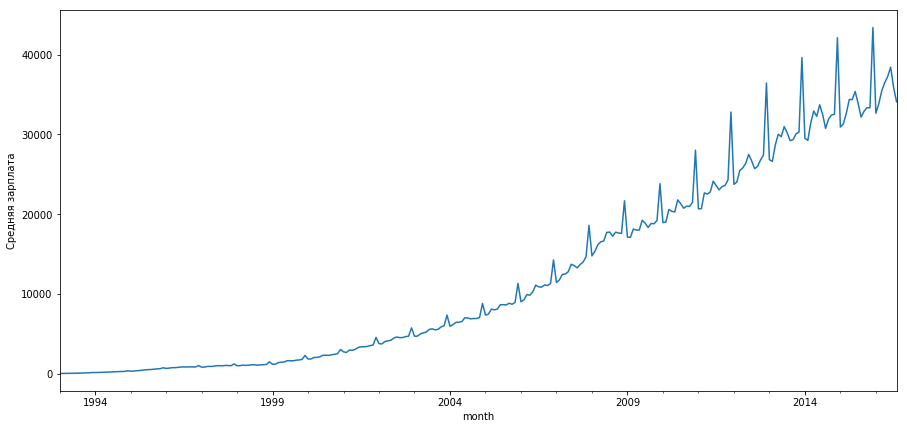

In [2]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary.salary.plot()
plt.ylabel('Средняя зарплата')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

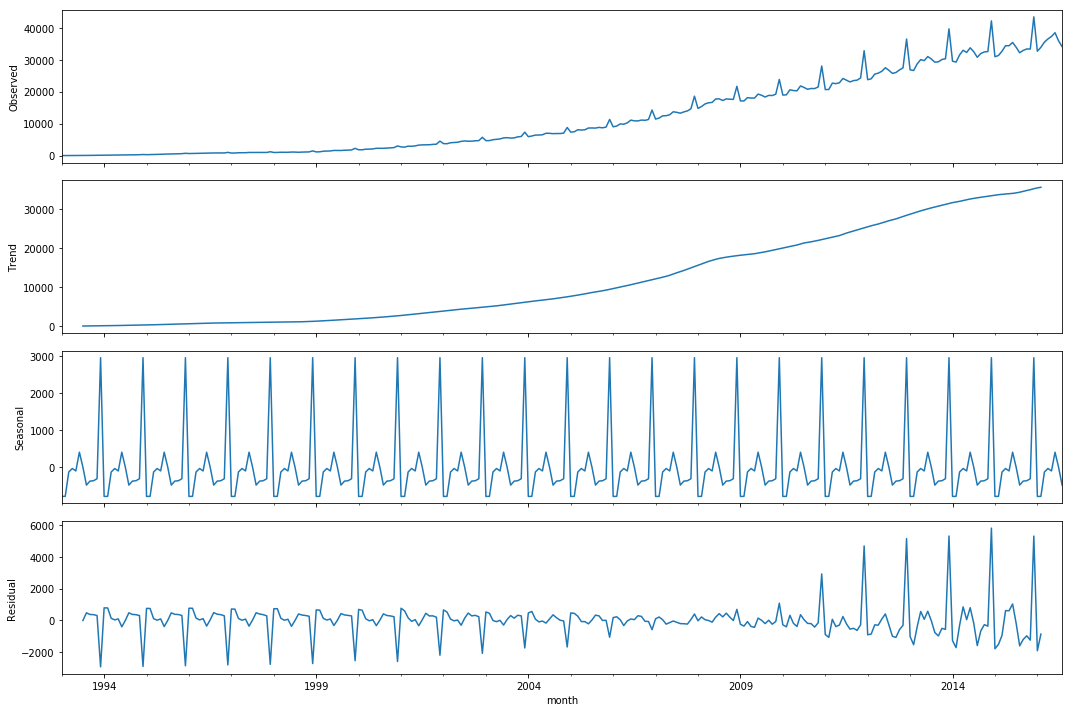

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


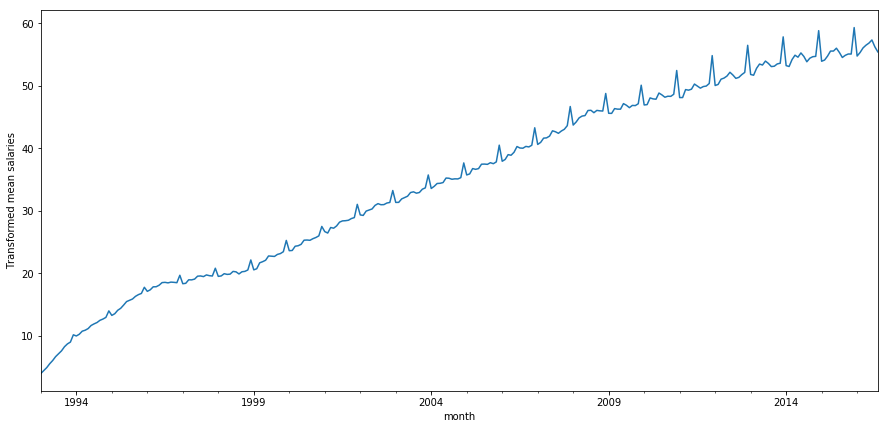

In [5]:
salary['salaries_box'], lmbda = stats.boxcox(salary.salary)
plt.figure(figsize(15,7))
salary.salaries_box.plot()
plt.ylabel(u'Transformed mean salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salaries_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

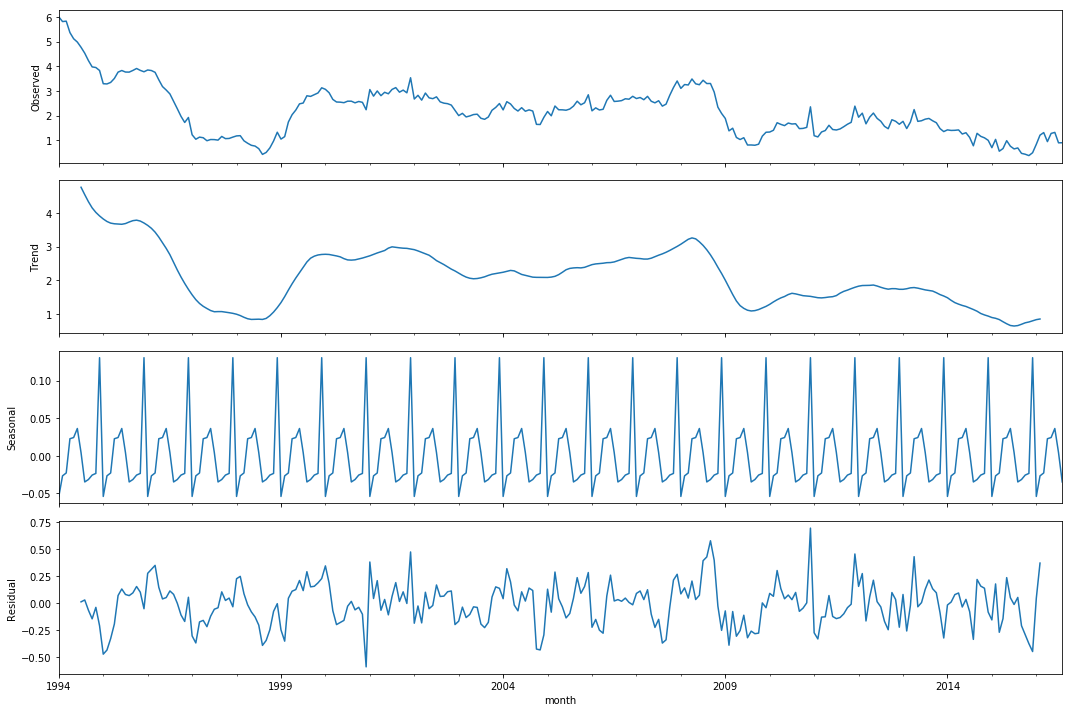

In [6]:
salary['salaries_box_diff'] = salary.salaries_box - salary.salaries_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salaries_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salaries_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

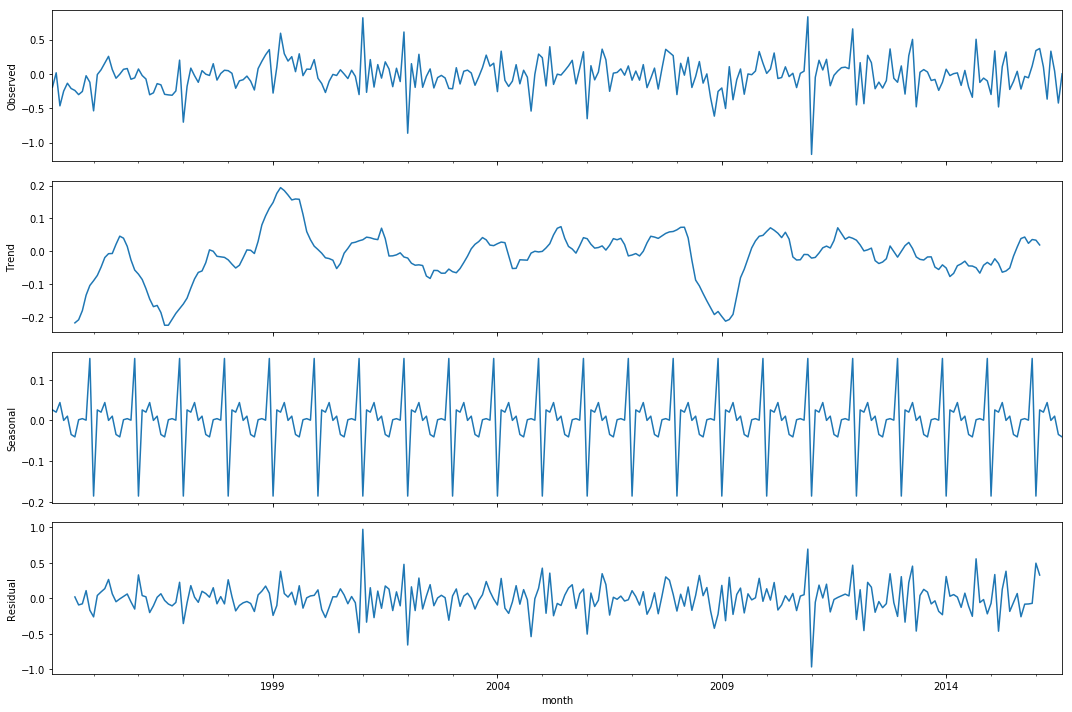

In [9]:
salary['salaries_box_diff2'] = salary.salaries_box_diff - salary.salaries_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salaries_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salaries_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

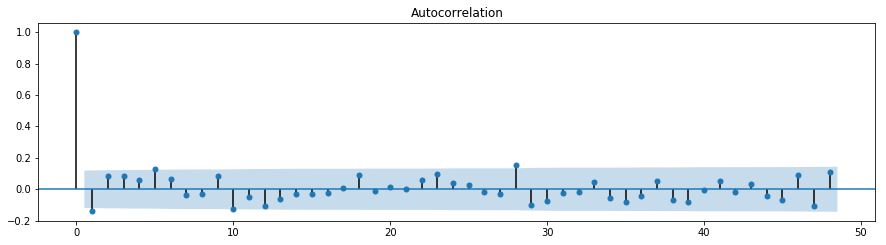

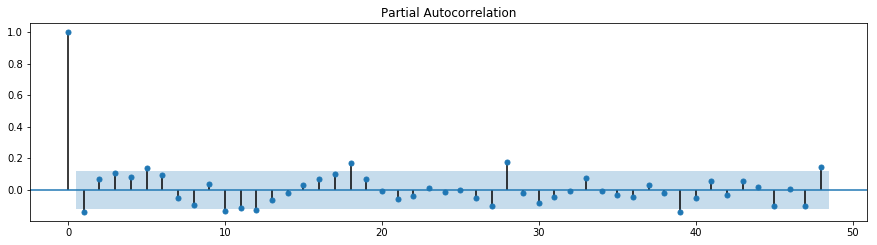

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salaries_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salaries_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=5, P=1, p=5

In [23]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [24]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [25]:
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salaries_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
142  (5, 5, 1, 0) -25.166471
141  (5, 5, 0, 1) -24.733346
118  (4, 5, 1, 0) -24.324093
143  (5, 5, 1, 1) -23.607890
117  (4, 5, 0, 1) -22.751566


Лучшая модель:

In [26]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       salaries_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.583
Date:                            Mon, 25 Nov 2019   AIC                            -25.166
Time:                                    20:00:13   BIC                             18.059
Sample:                                01-01-1993   HQIC                            -7.811
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2235      4.082     -0.055      0.956      -8.224       7.777
ar.L2          0.2324      2.902   

Её остатки:

Критерий Стьюдента: p=0.167702
Критерий Дики-Фуллера: p=0.000000


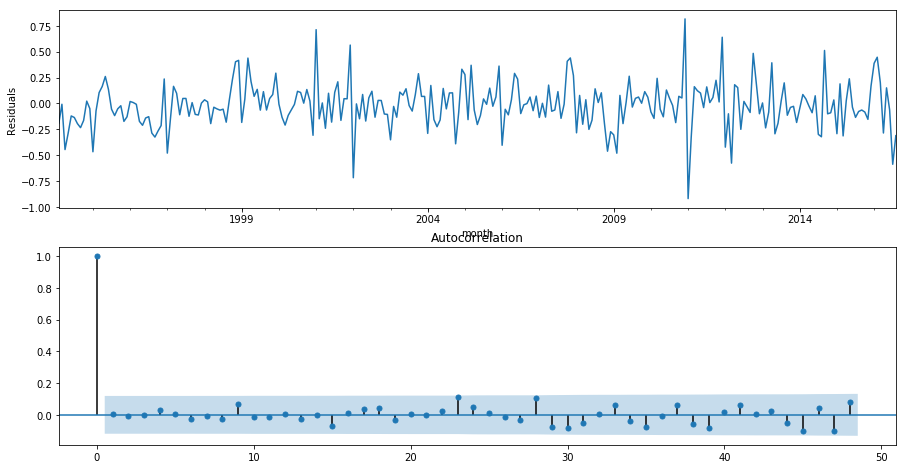

In [27]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

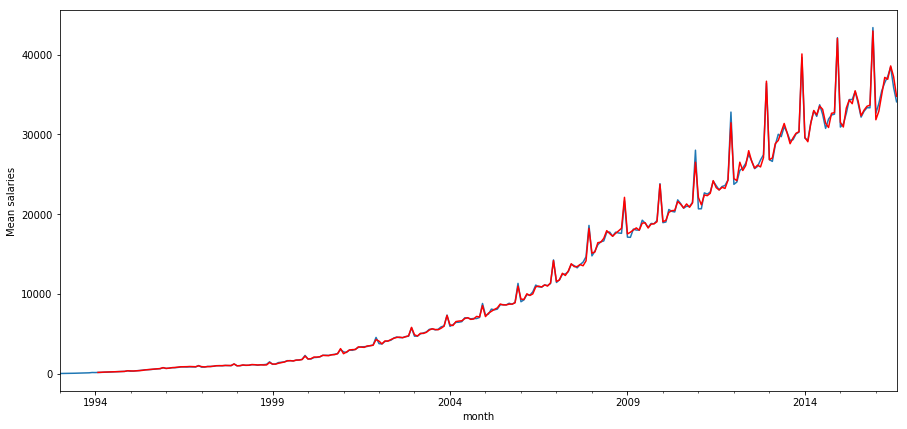

In [28]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.salary.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Mean salaries')
pylab.show()

### Прогноз

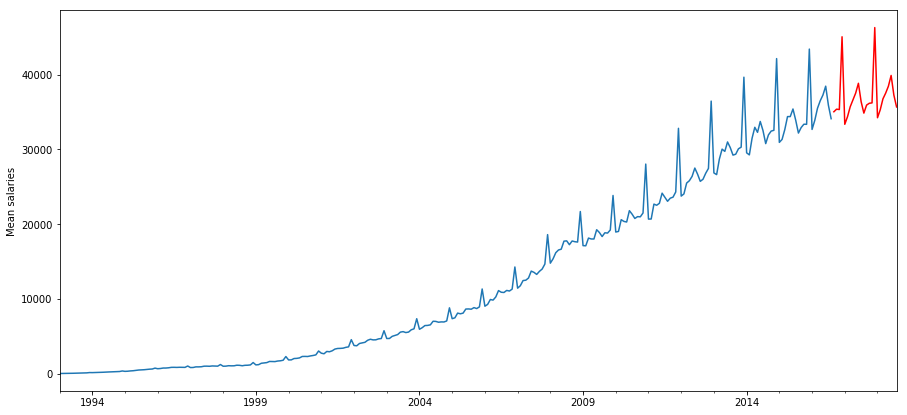

In [64]:
salary2 = salary[['salary']]
date_list = [datetime.datetime.strptime("01.09.2016", "%d.%m.%Y") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
salary2.salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Mean salaries')
pylab.show()